In [1]:
import sys
sys.path.insert(0,'C:\\Users\\Syahrir Ridha\\PycharmProjects\\NET_Solver\\')
from solver import PDE
import numpy as np
import torch
from mesh import Data, Mesh
from boundary import Dirichlet, Periodic, Neumann
#from boundary.Dirichlet import*
import matplotlib.pyplot as plt
from models import *
from models.neural_net import _init_weights,add_noise_to_weights
from models.activation import Sine, Swish

In [2]:
from models import Sine

In [3]:
Sine

models.neural_net.Sine

In [4]:
TAU = 0.1
ALPHA = 10

# velocity field
vel = lambda x,y: (2*y*(1-x**2), -2*x*(1-y**2))

class HO(PDE):
    def PDELoss(self, inputs, outputs):
        
        # compute first order derivative
        grads = self.compute_grad(outputs, inputs)
        dpdx, dpdy = grads[:,0], grads[:,1]
        
        # compute second order deravative
        dp2dx2 = self.compute_grad(dpdx, inputs)[:,0]
        dp2dy2 = self.compute_grad(dpdy, inputs)[:,1]
        
        # compute loss 
        x,y = inputs[:,0], inputs[:,1]
        u,v = vel(x,y)
        
        return {'PDE': u*dpdx + v*dpdy - TAU*(dp2dx2 + dp2dy2)}
    
# initiate the PDE 
pde = HO(inputs=('x','y'), outputs=('p'))

pass


In [5]:
# define meshing
x = np.linspace(-1,1,80)
y = np.linspace(0,1,40)

mesh = Mesh({'x':x, 'y':y})
pde.set_mesh(mesh)

In [6]:
mesh.device

'cpu'

In [7]:
# left and right boundary conditions
x1 = np.array([-1,1])
p = np.full(2*len(y),1. -np.tanh(ALPHA))
left_right_bound = Dirichlet({'x':x1, 'y':y}, {'p':p},name='left_right')
pde.add_boundary(left_right_bound)

In [8]:
# top boundary condition
p = np.full(len(x), 1-np.tanh(ALPHA))
top_bo = Dirichlet({'x':x, 'y':y[-1:]},{'p':p},name='top')
pde.add_boundary(top_bo)

In [9]:
#p

In [10]:
# bottom bc
x1, x2 = x[x<0], x[x>=0]
p1 = 1. + np.tanh(ALPHA*(2*x1+1))

# bottom left bc
bot_left = Dirichlet({'x':x1, 'y':y[:1]}, {'p':p1}, name='bottom_left')
pde.add_boundary(bot_left)

In [11]:
y[:1]

array([0.])

In [12]:
# bottom right
class Neumann(Neumann):
    def neumann_loss(self, inputs, outputs):
        dpdy = self.compute_grad(outputs, inputs)[:,1]
        return {'gradY': dpdy}
    
bot_right = Neumann({'x':x2, 'y':y[:1]},name='bottom_right',device=mesh.device)
pde.add_boundary(bot_right)

In [13]:
btach_size = 1024
lr = 7e-3
epochs = 100
hid_dim = 256
layers = 5
in_dim = len(pde.input)
out_dim = len(pde.output)
activation = Sine()
#activation = torch.nn.Tanh()

net = Neural_Net(in_dim, hid_dim, out_dim, layers, act= activation)
#net.apply(add_noise_to_weights)
#net = MLP(in_dim,out_dim,layers,hid_dim)
optimizer = torch.optim.Adam(net.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = lr, pct_start=0.1, total_steps=epochs)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1,cycle_momentum=True)

pde.compile(net,optimizer, scheduler)

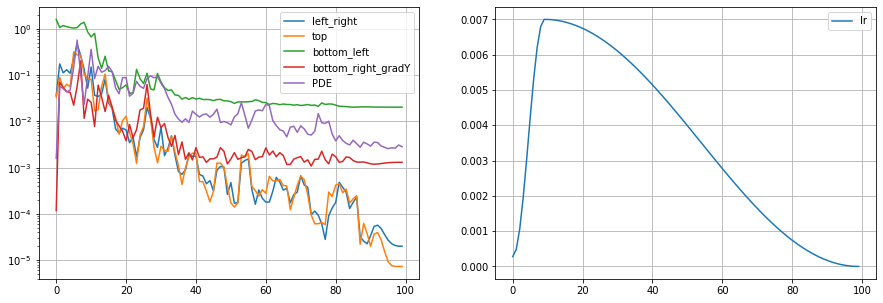

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  fig.canvas.print_figure(bytes_io, **kw)


Wall time: 1min 51s


In [14]:
%time hist = pde.solve(epochs, btach_size)

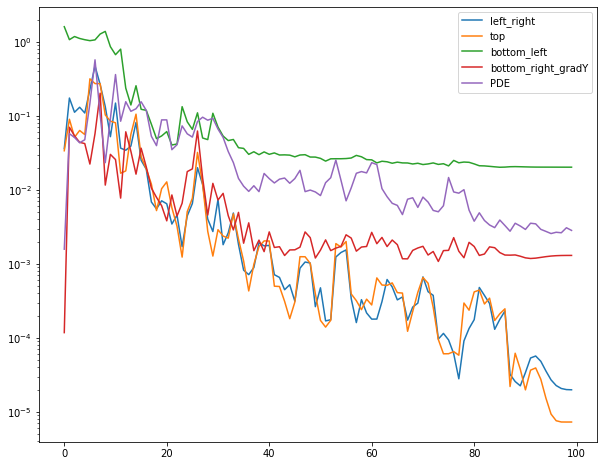

In [15]:
plt.figure(figsize=(10,8))
for key, value in hist.items():
    if key!= 'lr':
        plt.plot(hist[key],label=key)
        plt.legend()
    else:
        pass
    
    plt.yscale('log')

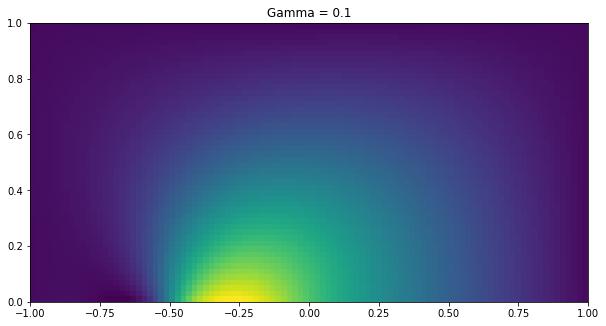

In [16]:
x = np.linspace(-1,1,100)
y = np.linspace(0,1,50)

eval_mesh = Mesh({'x':x, 'y':y})
pred = pde.eval(eval_mesh).view(len(y),len(x)).numpy()
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(pred, vmin=pred.min(),vmax= pred.max(), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
ax.set_title('Gamma = 0.1')
plt.show()

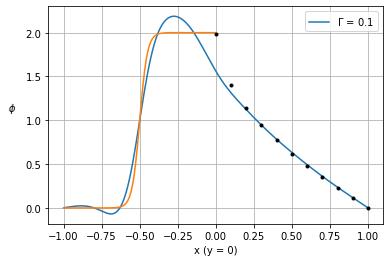

In [17]:
exp = {
    'x': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'g_0.1': [1.989,1.402,1.146,0.946,0.775,0.621,0.480,0.349,0.227,0.111,0.0],
    'g_0.001': [2.0000,1.9990,1.9997,1.985,1.841,0.951,0.154,0.001,0.0,0.0,0.0],
    'g_0.000001': [2.0000,2.0,2.0,1.999,1.964,1.0,0.036,0.001,0.0,0.0,0.0]
}

x = np.linspace(-1,1,200)
y = np.array([0])
eval_mesh = Mesh({'x': x, 'y': y})
p = pde.eval(eval_mesh).cpu().numpy().reshape(len(x))

plt.plot(x, p, label=f"$\\Gamma$ = 0.1")

p1 = 1. + np.tanh(ALPHA*(2*x[x<0]+1))
plt.plot(x[x<0], p1)

plt.plot(exp['x'], exp['g_0.1'], '.k')
plt.grid()
plt.xlabel('x (y = 0)')
plt.ylabel('$\\phi$       ', rotation=np.pi/2)
plt.legend()
plt.show()